## Setup

https://github.com/rivera-lanasm/nist_ppfl/blob/master/NIST_PPFL_problem1_202503/submission/README.md

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Change this as needed
%cd /content/drive/MyDrive/CMU课件/Eng Priv作业/ML_Colab


/content/drive/MyDrive/CMU课件/Eng Priv作业/ML_Colab


In [3]:
# Core scientific packages (already installed in Colab, but safe to include)
!pip install numpy pandas matplotlib torch torchvision torchinfo --quiet

# Adversarial Robustness Toolbox (ART)
!pip install adversarial-robustness-toolbox --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 88.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 55.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 30.8 MB/s eta 0:00:00


In [4]:
# helper functions
from utils import load_model, load_data, load_path_set, build_attack_model
# pre trained models
from attack_targets.cnn.model import Net as cnn_Net
from attack_targets.dpcnn10.model import Net as dpcnn10_Net
from attack_targets.dpcnn200.model import Net as dpcnn200_Net
# other packages
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary

# ART membership inference helper methods
from art.attacks.inference.membership_inference import MembershipInferenceBlackBox
from art.estimators.classification import PyTorchClassifier

## NIST Genomics PPFL Red Team Exercise


#### Introductory tutorial for performing Membership Inference Attack on CNN trained on Soybean Genomics data

In [5]:
CLIENT_ID_SET = ['1', '2', '3', '4']
challenge_pred_set = []

In [6]:
MODEL_TYPE = 'cnn'  # 'dpcnn' or 'cnn'
PRIVACY_TYPE = 'cnn'  # 'cnn' (no privacy), 'dpcnn10' (epsilon 10), dpcnn200 (epsilon 200)

In [7]:
# Path to challenge records data file for the client model
model_dir = Path(f'attack_targets/{PRIVACY_TYPE}')
challenge_data_path = Path(model_dir, f'{PRIVACY_TYPE}_challenge_records.dat')
print(challenge_data_path)
# Challenge records are those for which the competitor need to classify.
#   Each challenge record can be classified into 5 categories.
#   If a challenge record belongs to the client model, the competitor should classify it as the client number (1, 2, 3, or 4).
#   Otherwise, the competitor should classify it as 0 --> which means the record does not belong to any client model in the selected privacy level / privacy type.
challenge_x, challenge_y = load_data(challenge_data_path)
print("shape, challenge records: {}".format(challenge_x.shape))


attack_targets/cnn/cnn_challenge_records.dat
shape, challenge records: (73, 125766)


In [8]:
# attack model dict
attack_model_dict = {}

# train each client attack model
for client_id in CLIENT_ID_SET:
    print("Process attack model for client {}".format(int(client_id)))
    # load data and pre-trained model paths
    model_path, relevant_data_path, external_data_path, hyperparameters_path = load_path_set(privacy_type=PRIVACY_TYPE,
                                                                                             client_id=client_id,
                                                                                             model_type=MODEL_TYPE)

    # Relevant records are those which an attacker might believe belongs to the client model.
    print(relevant_data_path)
    rel_x, rel_y = load_data(relevant_data_path)
    print("shape, relevant records: {}".format(rel_x.shape))

    # External records are those which an attacker believes do not belong to the client model. See problem statement for details.
    ext_x, ext_y = load_data(external_data_path)
    print(external_data_path)
    print("shape, external records: {}".format(ext_x.shape))
    print("==========\n")

    # load architecture for pre-trained clients (target of MI attack)
    if PRIVACY_TYPE == "cnn":
        model_class = cnn_Net
    elif PRIVACY_TYPE == "dpcnn10":
        model_class = dpcnn10_Net
    elif PRIVACY_TYPE == "dpcnn200":
        model_class = dpcnn200_Net
    else:
        raise ValueError("invalid model type")

    task_model = load_model(model_path=model_path,
                            num_data_features=rel_x.shape[1],
                            model_class=model_class)

    # build attack model
    attack_model = build_attack_model(task_model=task_model,
                                      num_data_features=rel_x.shape[1],
                                      hyperparameters_path=hyperparameters_path)


    # Get client model's predictions on relevant and external data
    rel_x_preds = task_model(rel_x).squeeze()
    ext_x_preds = task_model(ext_x).squeeze()
    rel_x_preds = rel_x_preds.detach().numpy()
    ext_x_preds = ext_x_preds.detach().numpy()

    # Train attack model by passing relevant set as x and external set as test_x
    attack_model.fit(
        # features from relevant records
        x=rel_x,
        # outcome (soybean class) labels from relevant records
        y=rel_y,
        # features from external records
        test_x=ext_x,
        # outcome (soybean class) labels from external records
        test_y=ext_y,
        # prediction (logits) from pre trained classifier (for a given client) on relevant records
        pred=rel_x_preds,
        # prediction (logits) from pre trained classifier (for a given client) on external records
        test_pred=ext_x_preds
        )

    # append fitted attack model
    attack_model_dict[client_id] = attack_model

    # evaluate challenge records
    challenge_pred = attack_model.infer(x=challenge_x, y=challenge_y, probabilities=True)

    # challenge data predictions
    # challenge_pred = eval_model(rel_x_preds, ext_x_preds, rel_y, ext_y, attack_model, rel_x, ext_x, challenge_x, challenge_y)

    # assign
    challenge_pred_set.append(challenge_pred)

Process attack model for client 1
attack_targets/cnn/client_1/cnn_1_relevant_records.dat
shape, relevant records: (73, 125766)
attack_targets/cnn/client_1/cnn_1_external_records.dat
shape, external records: (64, 125766)

Process attack model for client 2
attack_targets/cnn/client_2/cnn_2_relevant_records.dat
shape, relevant records: (95, 125766)
attack_targets/cnn/client_2/cnn_2_external_records.dat
shape, external records: (83, 125766)

Process attack model for client 3
attack_targets/cnn/client_3/cnn_3_relevant_records.dat
shape, relevant records: (59, 125766)
attack_targets/cnn/client_3/cnn_3_external_records.dat
shape, external records: (52, 125766)

Process attack model for client 4
attack_targets/cnn/client_4/cnn_4_relevant_records.dat
shape, relevant records: (23, 125766)
attack_targets/cnn/client_4/cnn_4_external_records.dat
shape, external records: (20, 125766)



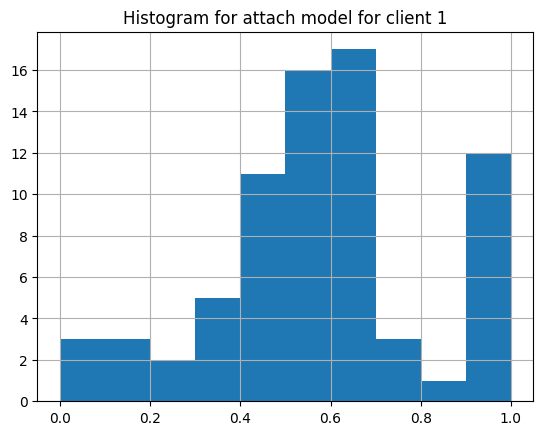

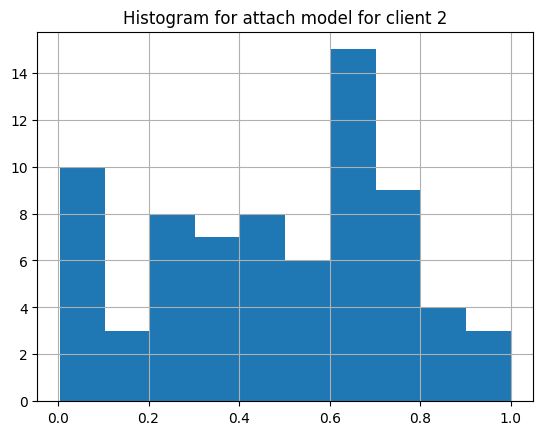

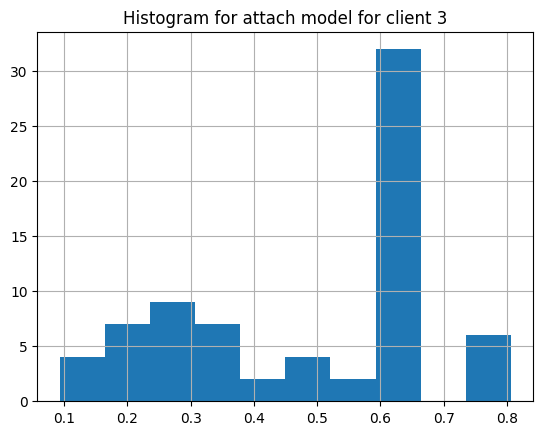

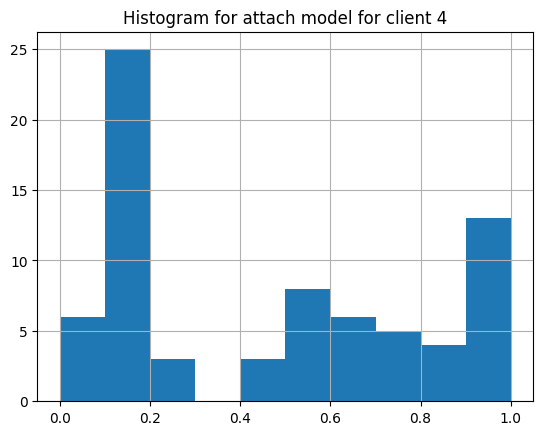

In [9]:
for i, val in enumerate(challenge_pred_set):
    plt.figure()
    pd.Series(val.reshape(1,-1)[0]).hist()
    plt.title(f"Histogram for attach model for client {i+1}")
    plt.show()

In [10]:
# assigning predictions for each challenge record to one of four clients (or none)

# Stack them into a single array of shape (4, N)
stacked = np.stack(challenge_pred_set, axis=0)

# Get the maximum value and index across arrays
max_values = np.max(stacked, axis=0)
max_indices = np.argmax(stacked, axis=0)

# Apply condition: only keep indices where max value >= 0.5
# ---> ASSUMPTION
result_indices = np.where(max_values >= 0.5, max_indices, 4)

# reshape
result_indices = result_indices.reshape(1,-1)[0]
# for formatting, add 1 and then mod 5 to each resulting val
    # we we want "5" to map to 0 (meaning no attack model is not confident)
result_indices = (result_indices + 1) % 5

result_indices = result_indices.reshape(1,-1)[0]

In [11]:
# return output format
output = pd.DataFrame({"index":np.arange(result_indices.shape[0]), "prediction":result_indices})

if PRIVACY_TYPE == "cnn":
    file_name = "cnn_submission_file"
elif PRIVACY_TYPE == "dpcnn10":
    file_name = "dpcnn10_submission_file"
elif PRIVACY_TYPE == "dpcnn200":
    file_name = "dpcnn200_submission_file"

print(file_name)
output.to_csv("{}.csv".format(file_name), index=False)
output.head()

cnn_submission_file


,index,prediction
0,0,4
1,1,2
2,2,1
3,3,4
4,4,4


In [12]:
output["prediction"].value_counts()

,count
prediction,
4,22
1,21
2,15
3,11
0,4


#### Now, let's see how good this approach is for client 4 across the three privacy conditions




- We have access to the indices from the challenge records corresponding to client #4 across the 3 privacy conditions
- So correctly identifying these records indicates how good our client 4 model is relative to the other models
- perhaps we don't just care that we **correctly** identify these records as corresponding to client 4 - we care about the ratio of the client 4 prediction vs the average of the predictions in favor of the other 3 clients
    - value close to 1 indicates that we don't have very high confidence
    - value greater than 1 indicates higher confidence


#### Relevant Records

**CNN: No DP**

**CNN: DP, 10**

**CNN: DP, 200**


number of positive class instances: 39
number of total instances: 59


Positive Class Recall In Challenge Records: 87.18%
Positive Class Precision In Challenge Records: 5.08%


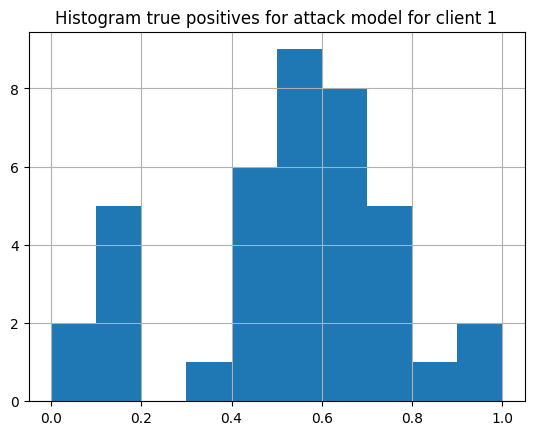

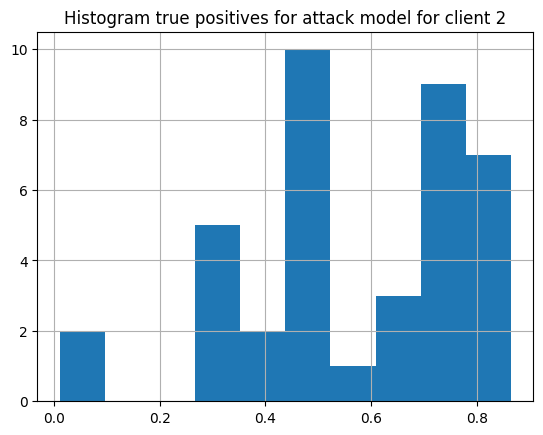

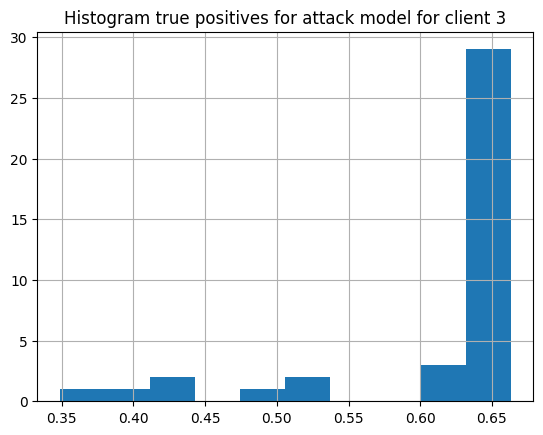

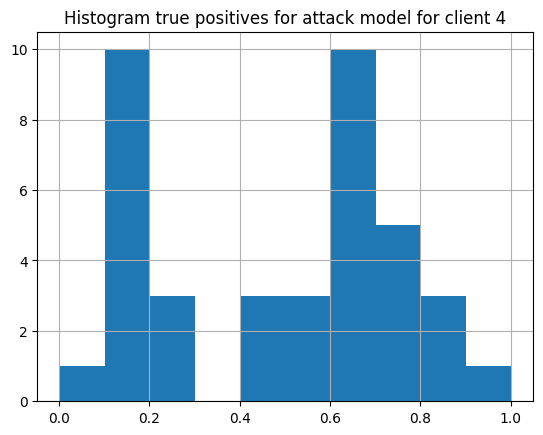

In [13]:
# ================================================================
# ========= ONLY CLIENT 4 AVAILABLE FOR CHALLENGE RECORD EVAL
# ================================================================
client_id = '3'

# ================================================================
# Load Relevant Record member indices and relevant member indices

# load data and pre-trained model paths
model_path, relevant_data_path, external_data_path, hyperparameters_path = load_path_set(privacy_type=PRIVACY_TYPE,
                                                                                            client_id=client_id,
                                                                                            model_type=MODEL_TYPE)

# Relevant records are those which an attacker might believe belongs to the client model.
rel_x, rel_y = load_data(relevant_data_path)

# filter for client we selected
client_mask = rel_y == (int(client_id) - 1)
print("number of positive class instances: {}".format(sum(client_mask)))
print("number of total instances: {}".format(len(client_mask)))
print("\n")
true_rel_x = rel_x[client_mask]
true_rel_y = rel_y[client_mask]


# =============================================
# load fitted attack model
fitted_attack_model = attack_model_dict[client_id]

# ==============================================
# RECALL for pos class:

# Run attack model on these true member records
preds = fitted_attack_model.infer(x=true_rel_x, y=true_rel_y)

# Positive recall: % of true members predicted as members
true_members_correct = np.sum(preds == 1)
positive_recall = (true_members_correct / len(preds)) * 100
print('Positive Class Recall In Challenge Records:', f'{round(positive_recall, 2)}%')

# ==============================================
# PRECISION for pos class:

# Load relevant records
rel_x, rel_y = load_data(relevant_data_path)

# Ground truth labels: 1 if record belongs to client, else 0
y_true = (rel_y == int(client_id)).astype(int)

# Run attack model on all relevant records
preds = fitted_attack_model.infer(x=rel_x, y=rel_y)

# Positive precision: TP / (TP + FP)
true_positives = np.sum((preds == 1) & (y_true == 1))
false_positives = np.sum((preds == 1) & (y_true == 0))
positive_precision = (true_positives / (true_positives + false_positives)) * 100 if (true_positives + false_positives) > 0 else 0.0

print('Positive Class Precision In Challenge Records:', f'{round(positive_precision, 2)}%')

# ==============================================
# distribution of confidence among true positivies

for k, fitted_m in attack_model_dict.items():

# fitted_attack_model = attack_model_dict[client_id]

  challenge_pred = fitted_m.infer(x=true_rel_x, y=true_rel_y, probabilities=True)
  plt.figure()
  pd.Series(challenge_pred.reshape(1,-1)[0]).hist()
  plt.title(f"Histogram true positives for attack model for client {int(k)}")
  plt.show()



#### Challenge Records (only available for client 4)


In [14]:
# ================================================================
# ========= ONLY CLIENT 4 AVAILABLE FOR CHALLENGE RECORD EVAL
# ================================================================
client_id = '4'

# ============a====================================================
# Load Challenge member indices and relevant member indices
challenge_members_path = Path(f'attack_targets/{PRIVACY_TYPE}/client_{client_id}', f'{MODEL_TYPE}_4_challenge_members.json')

with open(challenge_members_path, 'r') as f:
    challenge_members_dict = json.load(f)

challenge_members = list(challenge_members_dict['challenge members'])

print("number of positive instances among challenge members: {}".format(len(challenge_members)))

# =============================================
# load fitted attack model
fitted_attack_model = attack_model_dict[client_id]

# ==============================================
# RECALL for pos class:

# Get true client 4 members in challenge data
true_client_4_members_x = challenge_x[challenge_members]
true_client_4_members_y = challenge_y[challenge_members]

preds = fitted_attack_model.infer(x=true_client_4_members_x,
                                  y=true_client_4_members_y)
true_members_correct = np.sum((preds == 1))
# Calculate percentage of predicting true members as members by the attack model
true_members_percentage = (true_members_correct / len(preds)) * 100
print('Positive Class Recall In Challenge Records: ', f'{round(true_members_percentage, 2)}%')

# ==============================================
# PRECISION for pos class:

# Ground truth labels for all challenge records: 1 for members, 0 otherwise
y_true = np.zeros(len(challenge_x), dtype=int)
y_true[challenge_members] = 1

preds = fitted_attack_model.infer(x=challenge_x,
                                  y=challenge_y)

# Precision = TP / (TP + FP)
true_positives = np.sum((preds == 1) & (y_true == 1))
false_positives = np.sum((preds == 1) & (y_true == 0))

precision = (true_positives / (true_positives + false_positives)) * 100 if (true_positives + false_positives) > 0 else 0.0
print('Positive Class Precision In Challenge Records:', f'{round(precision, 2)}%')



# ==============================================
# but did we correctly **reject** non client 4 members?
# Get true client 4 non-members in challenge data
non_member_indices = list(set(range(challenge_x.shape[0])) - set(challenge_members))
true_client_4_non_members_x = challenge_x[non_member_indices]
true_client_4_non_members_y = challenge_y[non_member_indices]
# Infer membership on true client 4 non-members
preds = fitted_attack_model.infer(x=true_client_4_non_members_x,
                                  y=true_client_4_non_members_y)
true_non_members_correct = np.sum((preds == 0))
# Calculate percentage of predicting true non-members as non-members by the attack model
true_non_members_percentage = (true_non_members_correct / len(preds)) * 100
print('Negative Class Recall: In Challenge Records: ', f'{round(true_non_members_percentage, 2)}%')

# =================================================
# negative class precision

# Ground truth: 1 = member, 0 = non-member
y_true = np.zeros(len(challenge_x), dtype=int)
y_true[challenge_members] = 1

# Model predictions: 1 = predicted member, 0 = predicted non-member
preds = fitted_attack_model.infer(x=challenge_x, y=challenge_y)

# True negatives: predicted non-member & actually non-member
true_negatives = np.sum((preds == 0) & (y_true == 0))
# False negatives: predicted non-member but actually a member
false_negatives = np.sum((preds == 0) & (y_true == 1))

# Negative precision: TN / (TN + FN)
neg_precision = (true_negatives / (true_negatives + false_negatives)) * 100 if (true_negatives + false_negatives) > 0 else 0.0
print('Negative Class Precision In Challenge Records:', f'{round(neg_precision, 2)}%')



number of positive instances among challenge members: 2
Positive Class Recall In Challenge Records:  100.0%
Positive Class Precision In Challenge Records: 2.74%
Negative Class Recall: In Challenge Records:  52.11%
Negative Class Precision In Challenge Records: 97.26%


## Experiment Part 1: 3 Privacy Types






### Model and evaluation setup

In [51]:
# Import libraries needed specifically for visualization
import seaborn as sns
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

def evaluate_membership_inference(privacy_type="cnn"):
    """
    Evaluate membership inference attack performance for a given privacy type

    Args:
        privacy_type (str): Model privacy type: "cnn", "dpcnn10", or "dpcnn200"

    Returns:
        dict: Dictionary containing evaluation metrics for each client
    """
    print(f"Evaluating membership inference attack on {privacy_type} model")

    # Load necessary data paths and models
    CLIENT_ID_SET = ['1', '2', '3', '4']
    attack_model_dict = {}
    results = {}

    # Challenge data loading - fixed path according to file structure
    model_dir = Path(f'attack_targets/{privacy_type}')
    challenge_data_path = Path(model_dir, f'{privacy_type}_challenge_records.dat')
    challenge_x, challenge_y = load_data(challenge_data_path)
    print(f"Challenge records shape: {challenge_x.shape}")

    # Train attack models for each client
    for client_id in CLIENT_ID_SET:
        print(f"\nProcessing client {client_id}")

        # Fixed path format based on actual file structure
        # For dpcnn10 and dpcnn200, the model files use 'dpcnn' prefix, not 'dpcnn10' or 'dpcnn200'
        prefix = "cnn" if privacy_type == "cnn" else "dpcnn"

        model_path = Path(f'attack_targets/{privacy_type}/client_{client_id}/{prefix}_{client_id}.torch')
        relevant_data_path = Path(f'attack_targets/{privacy_type}/client_{client_id}/{prefix}_{client_id}_relevant_records.dat')
        external_data_path = Path(f'attack_targets/{privacy_type}/client_{client_id}/{prefix}_{client_id}_external_records.dat')
        hyperparameters_path = Path(f'attack_targets/{privacy_type}/client_{client_id}/{prefix}_{client_id}_hyperparameters.json')

        # Check if files exist before loading
        if not model_path.exists():
            print(f"Warning: Model file not found: {model_path}")
            continue

        if not relevant_data_path.exists():
            print(f"Warning: Relevant data file not found: {relevant_data_path}")
            continue

        if not external_data_path.exists():
            print(f"Warning: External data file not found: {external_data_path}")
            continue

        if not hyperparameters_path.exists():
            print(f"Warning: Hyperparameters file not found: {hyperparameters_path}")
            continue

        # Load data
        rel_x, rel_y = load_data(relevant_data_path)
        ext_x, ext_y = load_data(external_data_path)
        print(f"Relevant records: {rel_x.shape}, External records: {ext_x.shape}")

        # Load appropriate model architecture
        if privacy_type == "cnn":
            model_class = cnn_Net
        elif privacy_type == "dpcnn10":
            model_class = dpcnn10_Net
        elif privacy_type == "dpcnn200":
            model_class = dpcnn200_Net
        else:
            raise ValueError("Invalid model type")

        # Load task model and build attack model
        task_model = load_model(
            model_path=model_path,
            num_data_features=rel_x.shape[1],
            model_class=model_class
        )

        attack_model = build_attack_model(
            task_model=task_model,
            num_data_features=rel_x.shape[1],
            hyperparameters_path=hyperparameters_path
        )

        # Get predictions from task model
        rel_x_preds = task_model(rel_x).squeeze().detach().numpy()
        ext_x_preds = task_model(ext_x).squeeze().detach().numpy()

        # Train attack model
        attack_model.fit(
            x=rel_x,
            y=rel_y,
            test_x=ext_x,
            test_y=ext_y,
            pred=rel_x_preds,
            test_pred=ext_x_preds
        )

        # Store attack model
        attack_model_dict[client_id] = attack_model

        # Evaluate on relevant data
        # Create binary labels (1 for members of this client, 0 otherwise)
        y_true = (rel_y == int(client_id) - 1).astype(int)

        # Get attack model predictions (binary and probability)
        binary_preds = attack_model.infer(x=rel_x, y=rel_y)
        prob_preds = attack_model.infer(x=rel_x, y=rel_y, probabilities=True)

        # Calculate confusion matrix values
        TP = np.sum((binary_preds == 1) & (y_true == 1))  # True Positive
        FP = np.sum((binary_preds == 1) & (y_true == 0))  # False Positive
        TN = np.sum((binary_preds == 0) & (y_true == 0))  # True Negative
        FN = np.sum((binary_preds == 0) & (y_true == 1))  # False Negative

        # Calculate metrics using the correct formulas
        # Accuracy = (TP + TN) / (TP + TN + FP + FN)
        accuracy = ((TP + TN) / (TP + TN + FP + FN)) * 100

        # Precision = TP / (TP + FP)
        positive_precision = (TP / (TP + FP)) * 100 if (TP + FP) > 0 else 0

        # Positive Recall (Recall for Members) = TP / (TP + FN)
        positive_recall = (TP / (TP + FN)) * 100 if (TP + FN) > 0 else 0

        # Negative Recall (Recall for Non-Members) = TN / (TN + FP)
        negative_recall = (TN / (TN + FP)) * 100 if (TN + FP) > 0 else 0

        # Negative Precision = TN / (TN + FN)
        negative_precision = (TN / (TN + FN)) * 100 if (TN + FN) > 0 else 0

        # F1 Score = 2 * (Precision * Recall) / (Precision + Recall)
        f1_score = 2 * (positive_precision * positive_recall) / (positive_precision + positive_recall) if (positive_precision + positive_recall) > 0 else 0

        # Store raw confusion matrix values for visualization
        raw_cm = {
            'TP': int(TP),  # Convert to int to avoid numpy type issues
            'FP': int(FP),
            'TN': int(TN),
            'FN': int(FN)
        }

        # Store results
        results[client_id] = {
            'TP': TP,
            'FP': FP,
            'TN': TN,
            'FN': FN,
            'accuracy': accuracy,
            'positive_precision': positive_precision,
            'positive_recall': positive_recall,
            'negative_recall': negative_recall,
            'negative_precision': negative_precision,
            'f1_score': f1_score,
            'binary_preds': binary_preds,
            'prob_preds': prob_preds,
            'y_true': y_true,
            'total_samples': len(binary_preds),
            'total_members': np.sum(y_true),
            'total_non_members': len(y_true) - np.sum(y_true),
            'raw_cm': raw_cm
        }

        print(f"Client {client_id} evaluation complete")

    return results, attack_model_dict

def visualize_results(results, privacy_type="cnn"):
    """
    Visualize evaluation results with histograms and confusion matrices

    Args:
        results (dict): Results dictionary from evaluate_membership_inference
        privacy_type (str): Model privacy type for plot titles
    """
    # Create figure for all clients
    plt.figure(figsize=(15, 12))
    plt.suptitle(f"Membership Inference Attack Results - {privacy_type}", fontsize=16)

    # Count how many clients have results
    valid_clients = [client_id for client_id in ['1', '2', '3', '4'] if client_id in results]
    num_clients = len(valid_clients)

    if num_clients == 0:
        plt.text(0.5, 0.5, f"No valid results for {privacy_type}",
                 ha='center', va='center', fontsize=20)
        plt.tight_layout()
        plt.savefig(f"{privacy_type}_evaluation_results.png", dpi=300)
        plt.show()
        return

    # Adjust subplot layout based on number of clients
    for idx, client_id in enumerate(valid_clients):
        client_results = results[client_id]

        # Histogram of membership probabilities
        plt.subplot(num_clients, 2, 2*idx+1)

        # Split probabilities for true members and true non-members
        member_probs = client_results['prob_preds'][client_results['y_true'] == 1]
        non_member_probs = client_results['prob_preds'][client_results['y_true'] == 0]

        plt.hist(member_probs, alpha=0.5, bins=20, label='Members', color='blue')
        plt.hist(non_member_probs, alpha=0.5, bins=20, label='Non-members', color='red')
        plt.title(f"Client {client_id} - Membership Probability Distribution")
        plt.xlabel("Membership Probability")
        plt.ylabel("Count")
        plt.legend()

        # Confusion matrix subplot - using the raw values stored in results
        plt.subplot(num_clients, 2, 2*idx+2)
        cm = np.array([
            [client_results['raw_cm']['TN'], client_results['raw_cm']['FP']],
            [client_results['raw_cm']['FN'], client_results['raw_cm']['TP']]
        ])

        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['Predicted Non-Member', 'Predicted Member'],
                   yticklabels=['True Non-Member', 'True Member'])
        plt.title(f"Client {client_id} - Confusion Matrix")

        # Print metrics
        print(f"\nClient {client_id} Metrics - {privacy_type}:")
        print(f"Total samples: {client_results['total_samples']}")
        print(f"Total true members: {client_results['total_members']}")
        print(f"Total non-members: {client_results['total_non_members']}")
        print(f"Accuracy: {client_results['accuracy']:.2f}%")
        print(f"Positive Class (Member) Recall: {client_results['positive_recall']:.2f}%")
        print(f"Positive Class (Member) Precision: {client_results['positive_precision']:.2f}%")
        print(f"Negative Class (Non-Member) Recall: {client_results['negative_recall']:.2f}%")
        print(f"Negative Class (Non-Member) Precision: {client_results['negative_precision']:.2f}%")
        print(f"F1 Score: {client_results['f1_score']:.2f}")

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.savefig(f"{privacy_type}_evaluation_results.png", dpi=300)
    plt.show()

def compare_models():
    """
    Compare performance of membership inference attacks across all privacy types

    Returns:
        tuple: Dictionary of results and comparison DataFrame
    """
    # Dictionary to store results for all models
    all_results = {}
    privacy_types = ["cnn", "dpcnn10", "dpcnn200"]  # Define privacy_types here
    all_comparison_data = []

    # Evaluate each privacy type
    for privacy_type in privacy_types:
        print(f"\n{'-'*50}")
        print(f"Evaluating {privacy_type} model")
        print(f"{'-'*50}")

        try:
            results, _ = evaluate_membership_inference(privacy_type)
            all_results[privacy_type] = results
            visualize_results(results, privacy_type)

            # Collect comparison data
            for client_id in results:
                client_results = results[client_id]
                all_comparison_data.append({
                    'Privacy Type': privacy_type,
                    'Client ID': client_id,
                    'Accuracy (%)': round(client_results['accuracy'], 2),
                    'Member Recall (%)': round(client_results['positive_recall'], 2),
                    'Member Precision (%)': round(client_results['positive_precision'], 2),
                    'Non-Member Recall (%)': round(client_results['negative_recall'], 2),
                    'Non-Member Precision (%)': round(client_results['negative_precision'], 2),
                    'F1 Score': round(client_results['f1_score'], 2)
                })
        except Exception as e:
            print(f"Error evaluating {privacy_type} model: {str(e)}")
            import traceback
            traceback.print_exc()
            continue

    # Convert to DataFrame and display
    comparison_df = pd.DataFrame(all_comparison_data)
    if not comparison_df.empty:
        print("\nComparison of Models:")
        print(comparison_df)

        # Save table to CSV
        comparison_df.to_csv("privacy_model_comparison.csv", index=False)
    else:
        print("No comparison data available. All evaluations failed.")

    return all_results, comparison_df

def run_evaluation_with_modified_parameters(privacy_type, threshold_value, model_configs):
    """
    Run evaluation with modified attack parameters

    Args:
        privacy_type (str): Model type to evaluate
        threshold_value (float): Confidence threshold value (fixed at 0.5)
        model_configs (list): Not used in this implementation

    Returns:
        DataFrame: Results of the parameter evaluation
    """
    all_parameter_results = []

    print(f"Testing with threshold={threshold_value} on {privacy_type} model")

    results, attack_models = evaluate_membership_inference(privacy_type)

    # Apply fixed threshold to the attack models
    for client_id in results:
        client_results = results[client_id]
        attack_model = attack_models[client_id]

        # Get probability predictions for relevant records
        model_dir = Path(f'attack_targets/{privacy_type}')

        # Fix path for different model types
        prefix = "cnn" if privacy_type == "cnn" else "dpcnn"
        relevant_data_path = Path(f'attack_targets/{privacy_type}/client_{client_id}/{prefix}_{client_id}_relevant_records.dat')
        rel_x, rel_y = load_data(relevant_data_path)

        # Create binary labels (1 for members of this client, 0 otherwise)
        y_true = (rel_y == int(client_id) - 1).astype(int)

        # Get probability predictions
        prob_preds = attack_model.infer(x=rel_x, y=rel_y, probabilities=True)

        # Apply threshold
        binary_preds = (prob_preds > threshold_value).astype(int)

        # Calculate confusion matrix values
        TP = np.sum((binary_preds == 1) & (y_true == 1))  # True Positive
        FP = np.sum((binary_preds == 1) & (y_true == 0))  # False Positive
        TN = np.sum((binary_preds == 0) & (y_true == 0))  # True Negative
        FN = np.sum((binary_preds == 0) & (y_true == 1))  # False Negative

        # Calculate metrics using the correct formulas
        accuracy = ((TP + TN) / (TP + TN + FP + FN)) * 100
        positive_precision = (TP / (TP + FP)) * 100 if (TP + FP) > 0 else 0
        positive_recall = (TP / (TP + FN)) * 100 if (TP + FN) > 0 else 0
        negative_recall = (TN / (TN + FP)) * 100 if (TN + FP) > 0 else 0
        negative_precision = (TN / (TN + FN)) * 100 if (TN + FN) > 0 else 0
        f1_score = 2 * (positive_precision * positive_recall) / (positive_precision + positive_recall) if (positive_precision + positive_recall) > 0 else 0

        # Store result
        all_parameter_results.append({
            'Parameter': 'Threshold',
            'Value': threshold_value,
            'Client ID': client_id,
            'Accuracy (%)': round(accuracy, 2),
            'Member Recall (%)': round(positive_recall, 2),
            'Member Precision (%)': round(positive_precision, 2),
            'Non-Member Recall (%)': round(negative_recall, 2),
            'Non-Member Precision (%)': round(negative_precision, 2),
            'F1 Score': round(f1_score, 2)
        })

    # Convert to DataFrame and display
    results_df = pd.DataFrame(all_parameter_results)
    print("\nResults with Modified Parameters:")
    print(results_df)

    # Save table to CSV
    results_df.to_csv(f"{privacy_type}_parameter_comparison.csv", index=False)

    return results_df

def analyze_threshold_effect(privacy_type, threshold_values):
    """
    Analyze the effect of different threshold values on model performance

    Args:
        privacy_type (str): Model type to evaluate
        threshold_values (list): List of threshold values to test

    Returns:
        DataFrame: Results of the threshold analysis
    """
    all_results = []

    print(f"Analyzing threshold effects on {privacy_type} model")

    # Get base results and attack models
    _, attack_models = evaluate_membership_inference(privacy_type)

    for threshold in threshold_values:
        print(f"\nTesting threshold = {threshold}")

        for client_id, attack_model in attack_models.items():
            # Fix path for different model types
            prefix = "cnn" if privacy_type == "cnn" else "dpcnn"
            relevant_data_path = Path(f'attack_targets/{privacy_type}/client_{client_id}/{prefix}_{client_id}_relevant_records.dat')
            rel_x, rel_y = load_data(relevant_data_path)

            # Create binary labels (1 for members of this client, 0 otherwise)
            y_true = (rel_y == int(client_id) - 1).astype(int)

            # Get probability predictions
            prob_preds = attack_model.infer(x=rel_x, y=rel_y, probabilities=True)

            # Apply threshold
            binary_preds = (prob_preds > threshold).astype(int)

            # Calculate confusion matrix values
            TP = np.sum((binary_preds == 1) & (y_true == 1))  # True Positive
            FP = np.sum((binary_preds == 1) & (y_true == 0))  # False Positive
            TN = np.sum((binary_preds == 0) & (y_true == 0))  # True Negative
            FN = np.sum((binary_preds == 0) & (y_true == 1))  # False Negative

            # Calculate metrics using the correct formulas
            accuracy = ((TP + TN) / (TP + TN + FP + FN)) * 100
            positive_precision = (TP / (TP + FP)) * 100 if (TP + FP) > 0 else 0
            positive_recall = (TP / (TP + FN)) * 100 if (TP + FN) > 0 else 0
            negative_recall = (TN / (TN + FP)) * 100 if (TN + FP) > 0 else 0
            negative_precision = (TN / (TN + FN)) * 100 if (TN + FN) > 0 else 0
            f1_score = 2 * (positive_precision * positive_recall) / (positive_precision + positive_recall) if (positive_precision + positive_recall) > 0 else 0

            # Store results
            all_results.append({
                'Threshold': threshold,
                'Client ID': client_id,
                'Accuracy (%)': round(accuracy, 2),
                'Member Recall (%)': round(positive_recall, 2),
                'Member Precision (%)': round(positive_precision, 2),
                'Non-Member Recall (%)': round(negative_recall, 2),
                'Non-Member Precision (%)': round(negative_precision, 2),
                'F1 Score': round(f1_score, 2)
            })

    # Convert to DataFrame
    results_df = pd.DataFrame(all_results)

    # Plot results
    plt.figure(figsize=(15, 10))
    plt.suptitle(f"Effect of Threshold on {privacy_type} Model Performance", fontsize=16)

    metrics = ['Accuracy (%)', 'Member Recall (%)', 'Member Precision (%)',
              'Non-Member Recall (%)', 'Non-Member Precision (%)', 'F1 Score']

    for i, metric in enumerate(metrics):
        plt.subplot(2, 3, i+1)

        for client_id in sorted(set(results_df['Client ID'])):
            client_data = results_df[results_df['Client ID'] == client_id]
            plt.plot(client_data['Threshold'], client_data[metric], marker='o', label=f'Client {client_id}')

        plt.title(f"Effect on {metric}")
        plt.xlabel("Threshold Value")
        plt.ylabel(metric)
        plt.grid(True, alpha=0.3)
        plt.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(f"{privacy_type}_threshold_analysis.png", dpi=300)
    plt.show()

    # Save results to CSV
    results_df.to_csv(f"{privacy_type}_threshold_analysis.csv", index=False)

    return results_df


### Evaluation of 3 models

Starting comparison of all model types...

--------------------------------------------------
Evaluating cnn model
--------------------------------------------------
Evaluating membership inference attack on cnn model
Challenge records shape: (73, 125766)

Processing client 1
Relevant records: (73, 125766), External records: (64, 125766)
Client 1 evaluation complete

Processing client 2
Relevant records: (95, 125766), External records: (83, 125766)
Client 2 evaluation complete

Processing client 3
Relevant records: (59, 125766), External records: (52, 125766)
Client 3 evaluation complete

Processing client 4
Relevant records: (23, 125766), External records: (20, 125766)
Client 4 evaluation complete

Client 1 Metrics - cnn:
Total samples: 73
Total true members: 25
Total non-members: 48
Accuracy: 34.25%
Positive Class (Member) Recall: 100.00%
Positive Class (Member) Precision: 34.25%
Negative Class (Non-Member) Recall: 0.00%
Negative Class (Non-Member) Precision: 0.00%
F1 Score: 51.02

C

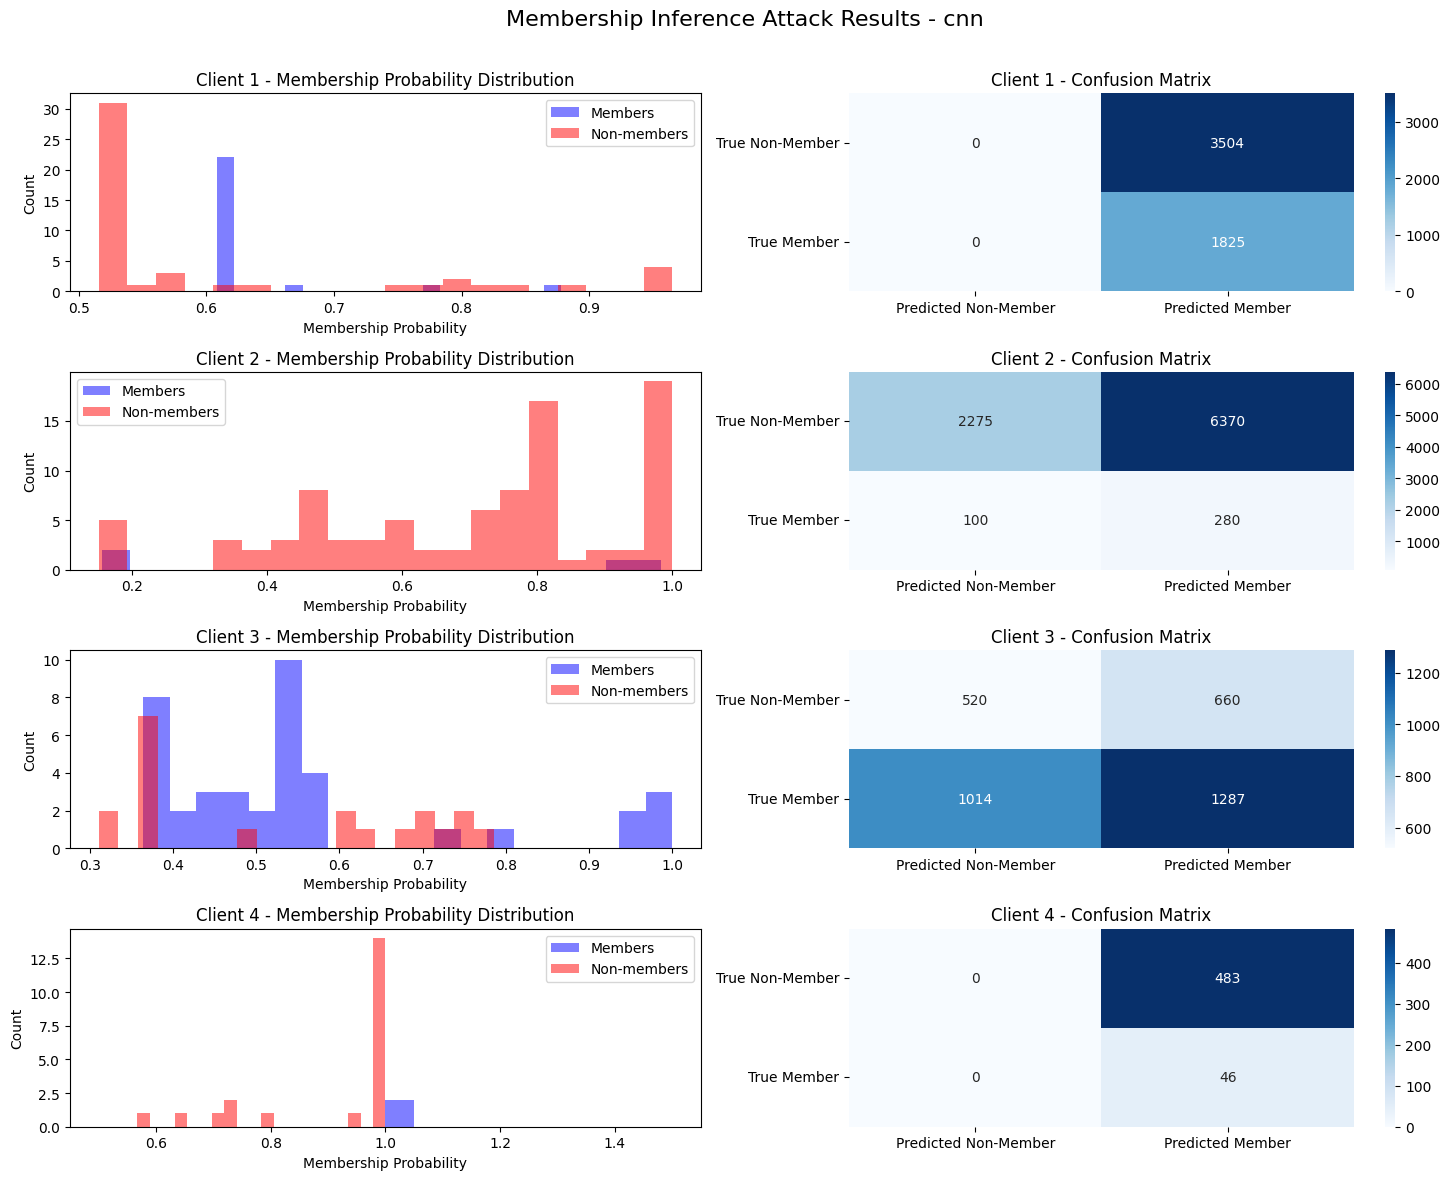


--------------------------------------------------
Evaluating dpcnn10 model
--------------------------------------------------
Evaluating membership inference attack on dpcnn10 model
Challenge records shape: (73, 125766)

Processing client 1
Relevant records: (73, 125766), External records: (64, 125766)
Client 1 evaluation complete

Processing client 2
Relevant records: (95, 125766), External records: (83, 125766)
Client 2 evaluation complete

Processing client 3
Relevant records: (59, 125766), External records: (52, 125766)
Client 3 evaluation complete

Processing client 4
Relevant records: (23, 125766), External records: (20, 125766)
Client 4 evaluation complete

Client 1 Metrics - dpcnn10:
Total samples: 73
Total true members: 27
Total non-members: 46
Accuracy: 44.12%
Positive Class (Member) Recall: 72.60%
Positive Class (Member) Precision: 36.99%
Negative Class (Non-Member) Recall: 27.40%
Negative Class (Non-Member) Precision: 63.01%
F1 Score: 49.01

Client 2 Metrics - dpcnn10:
To

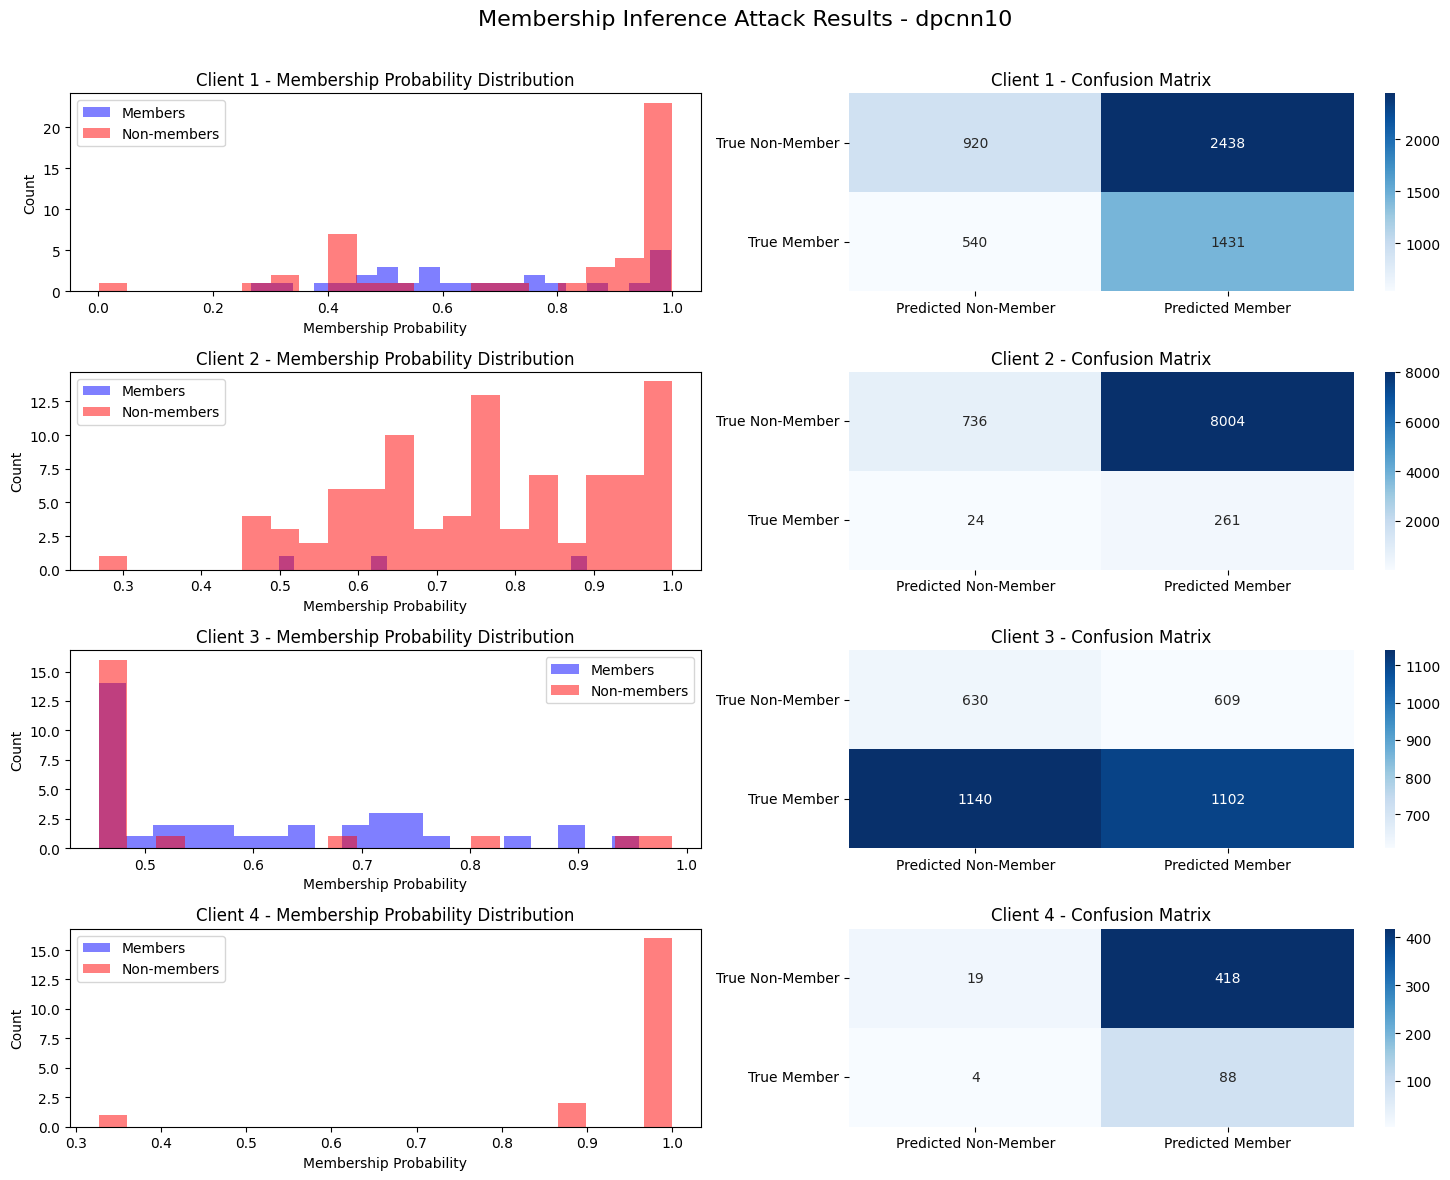


--------------------------------------------------
Evaluating dpcnn200 model
--------------------------------------------------
Evaluating membership inference attack on dpcnn200 model
Challenge records shape: (73, 125766)

Processing client 1
Relevant records: (73, 125766), External records: (64, 125766)
Client 1 evaluation complete

Processing client 2
Relevant records: (95, 125766), External records: (83, 125766)
Client 2 evaluation complete

Processing client 3
Relevant records: (59, 125766), External records: (52, 125766)
Client 3 evaluation complete

Processing client 4
Relevant records: (23, 125766), External records: (20, 125766)
Client 4 evaluation complete

Client 1 Metrics - dpcnn200:
Total samples: 73
Total true members: 21
Total non-members: 52
Accuracy: 43.31%
Positive Class (Member) Recall: 65.75%
Positive Class (Member) Precision: 28.77%
Negative Class (Non-Member) Recall: 34.25%
Negative Class (Non-Member) Precision: 71.23%
F1 Score: 40.02

Client 2 Metrics - dpcnn200

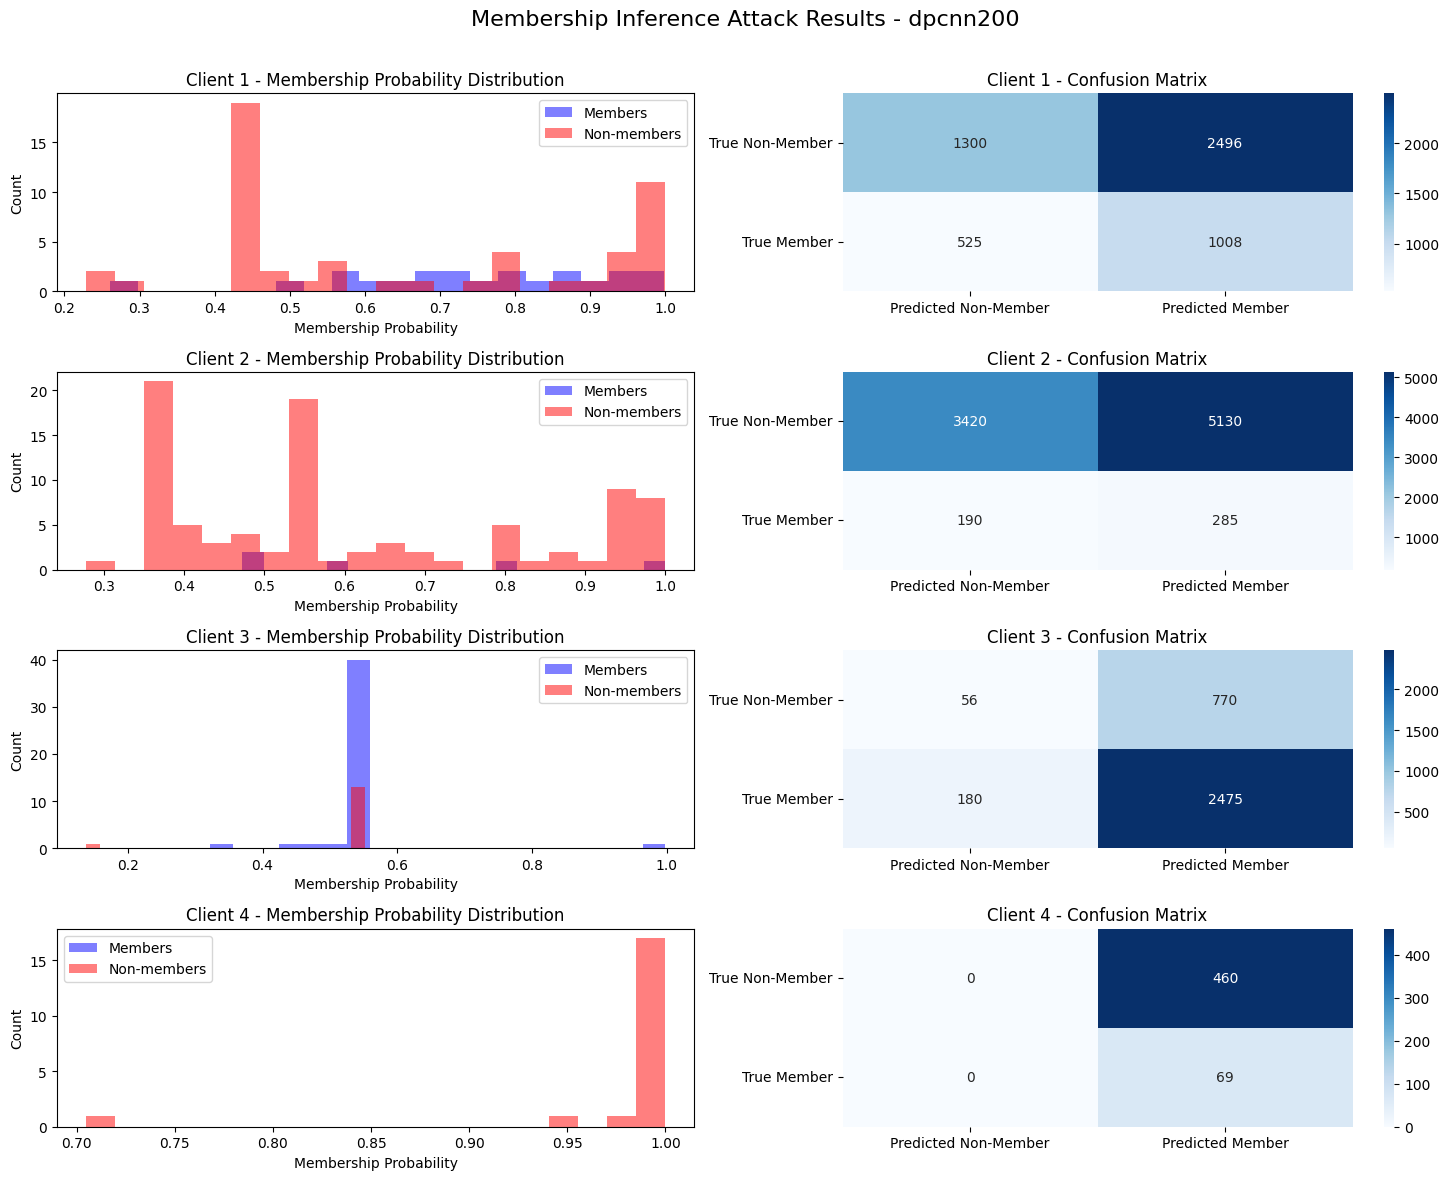


Comparison of Models:
   Privacy Type Client ID  Accuracy (%)  Member Recall (%)  \
0           cnn         1         34.25             100.00   
1           cnn         2         28.31              73.68   
2           cnn         3         51.91              55.93   
3           cnn         4          8.70             100.00   
4       dpcnn10         1         44.12              72.60   
5       dpcnn10         2         11.05              91.58   
6       dpcnn10         3         49.76              49.15   
7       dpcnn10         4         20.23              95.65   
8      dpcnn200         1         43.31              65.75   
9      dpcnn200         2         41.05              60.00   
10     dpcnn200         3         72.71              93.22   
11     dpcnn200         4         13.04             100.00   

    Member Precision (%)  Non-Member Recall (%)  Non-Member Precision (%)  \
0                  34.25                   0.00                      0.00   
1               

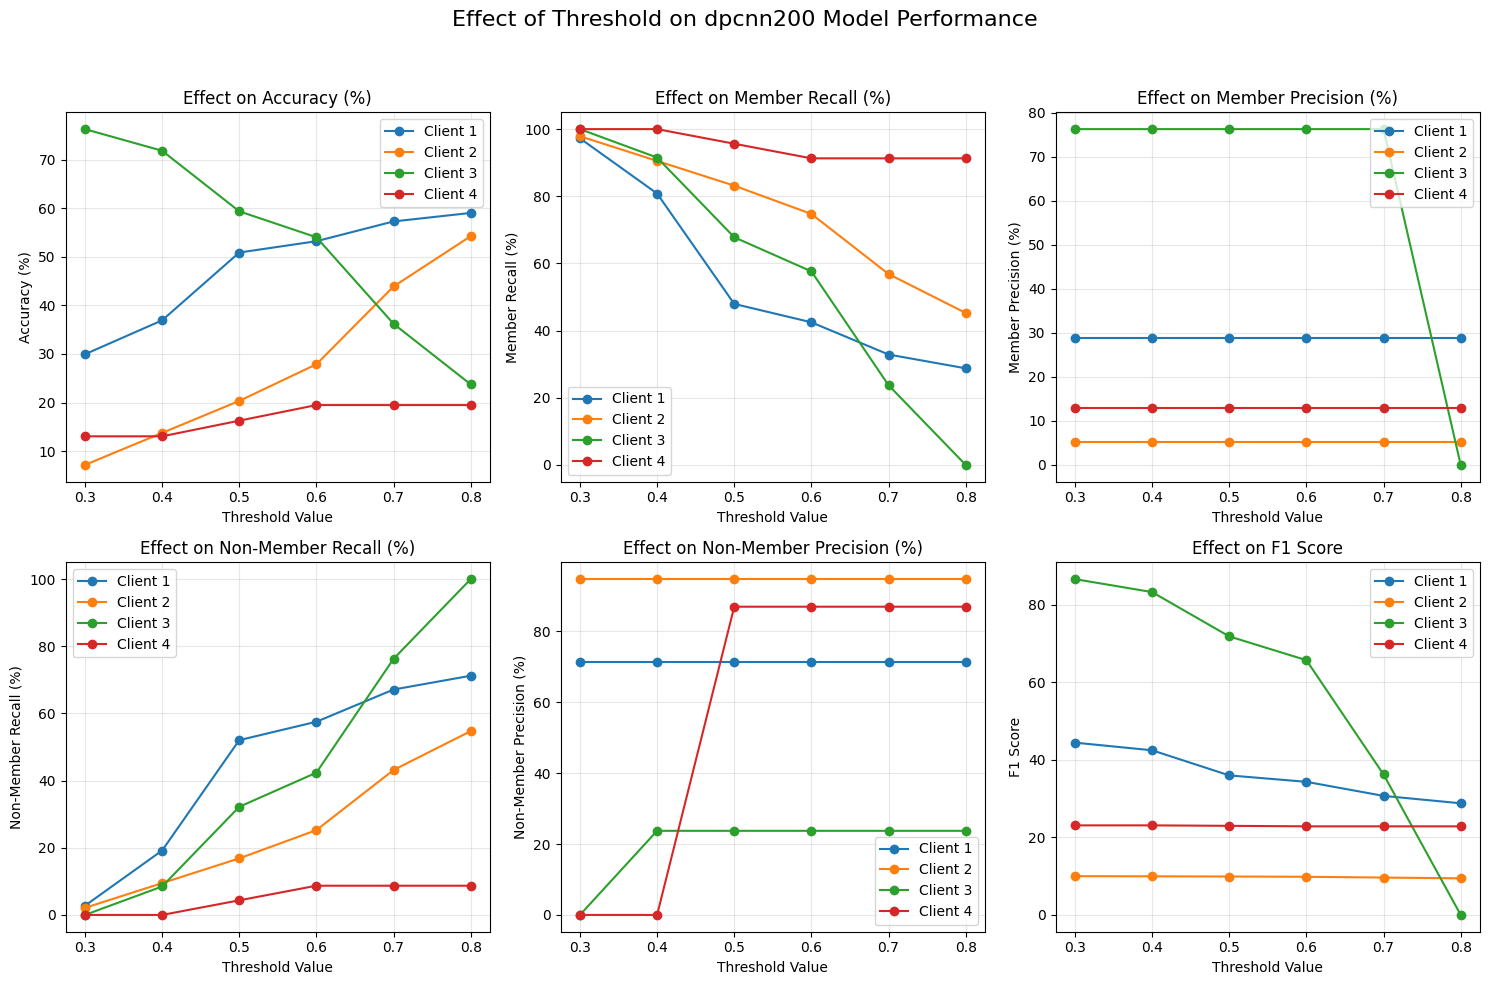


Evaluation complete.


In [52]:
if __name__ == "__main__":
    # Define the model type constant
    MODEL_TYPE = 'cnn'  # Or to 'dpcnn10' or 'dpcnn200' to evaluate

    # Define privacy types here to avoid error
    privacy_types = ["cnn", "dpcnn10", "dpcnn200"]

    # Step 1: Compare all model types
    print("Starting comparison of all model types...")
    all_results, comparison_df = compare_models()

    # Step 2: Find best performing model
    if not comparison_df.empty:
        # Calculate average accuracy for each privacy type
        model_performance = comparison_df.groupby('Privacy Type')['Accuracy (%)'].mean()
        if not model_performance.empty:
            best_model = model_performance.idxmax()
            print(f"\nBest performing model: {best_model} with average accuracy {model_performance[best_model]:.2f}%")

            # Step 3: Test fixed threshold parameter on all models
            threshold_value = 0.5  # Fixed threshold value
            model_configs = ["default"]  # This parameter is not used in this implementation

            for model_type in privacy_types:
                if model_type in all_results and all_results[model_type]:
                    print(f"\nTesting parameter modifications on {model_type} model...")
                    parameter_results = run_evaluation_with_modified_parameters(
                        model_type, threshold_value, model_configs
                    )

            # Experiment: Perform more detailed threshold analysis on the best model
            print(f"\nPerforming detailed threshold analysis on {best_model}...")
            threshold_values = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
            threshold_analysis = analyze_threshold_effect(best_model, threshold_values)
        else:
            print("No model performance data available.")
    else:
        print("No comparison data available. Check for errors in the evaluation process.")

    print("\nEvaluation complete.")

## Experiment Part 2: Parameter tuning for DPCNN10 on Client 3

### Batch size and Epochs

Starting parameter optimization for Client 3 DPCNN10 model
Loaded data - Relevant: (59, 125766), External: (52, 125766), Challenge: (73, 125766)
Original hyperparameters:
{
  "batch divisor": 15,
  "delta": 1e-05,
  "epochs": 100,
  "epsilon": 10.0,
  "learning rate": 0.003,
  "max grad norm": 2.0,
  "model id": 3,
  "optimizer": "sgd",
  "test fraction": 0.3,
  "total classes": 4,
  "weight decay": 0.0001
}

=== Optimizing Batch Size ===

Testing batch size: 16
Batch Size: 16, F1 Score: 48.57

Testing batch size: 32
Batch Size: 32, F1 Score: 49.86

Testing batch size: 64
Batch Size: 64, F1 Score: 78.35

Testing batch size: 128
Batch Size: 128, F1 Score: 55.76

Best batch size: 16 with F1 Score: 48.57

=== Optimizing Number of Epochs ===

Testing epochs: 5
Epochs: 5, F1 Score: 45.85

Testing epochs: 10
Epochs: 10, F1 Score: 39.82

Testing epochs: 20
Epochs: 20, F1 Score: 69.12

Testing epochs: 30
Epochs: 30, F1 Score: 52.33

Best epochs: 10 with F1 Score: 39.82

=== Optimal Parameters 

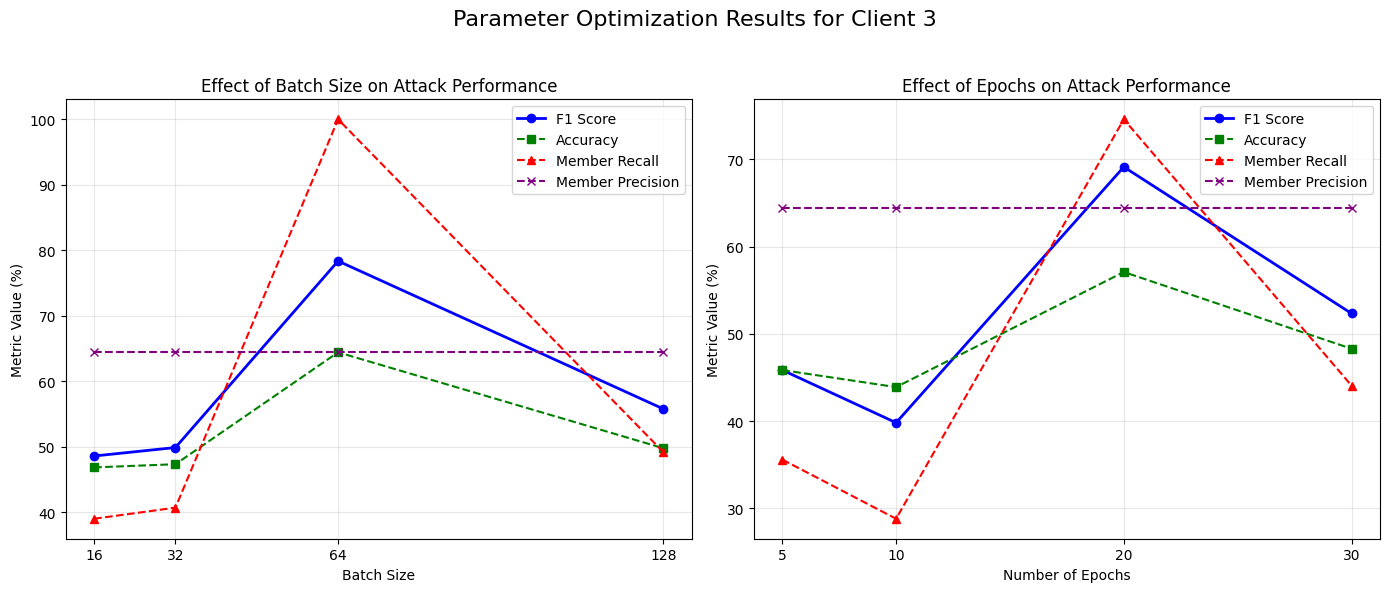

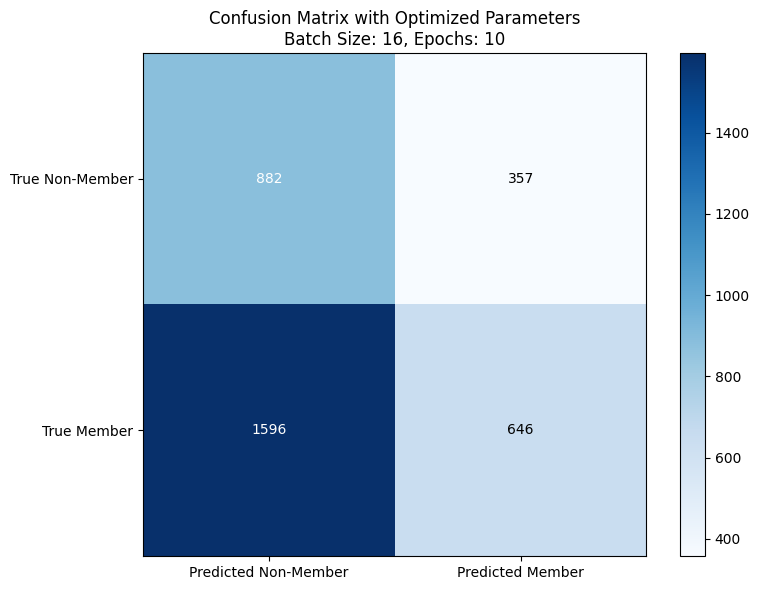

In [54]:
# File to fine-tune DPCNN10 model parameters for Client 3
# Focus on batch size and epoch optimization to improve privacy protection

import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import json

# For membership inference attack
from art.attacks.inference.membership_inference import MembershipInferenceBlackBox
from art.estimators.classification import PyTorchClassifier

# Import helper functions
from utils import load_model, load_data, load_path_set, build_attack_model
from attack_targets.dpcnn10.model import Net as dpcnn10_Net

def optimize_parameters_client3():
    """
    Optimize hyperparameters for Client 3 DPCNN10 model.
    Focus on batch size and epochs to improve privacy protection.
    """
    print("Starting parameter optimization for Client 3 DPCNN10 model")

    # Fixed paths for Client 3
    client_id = '3'
    privacy_type = 'dpcnn10'

    # Define file paths
    model_path = Path(f'attack_targets/{privacy_type}/client_{client_id}/dpcnn_{client_id}.torch')
    relevant_data_path = Path(f'attack_targets/{privacy_type}/client_{client_id}/dpcnn_{client_id}_relevant_records.dat')
    external_data_path = Path(f'attack_targets/{privacy_type}/client_{client_id}/dpcnn_{client_id}_external_records.dat')
    hyperparameters_path = Path(f'attack_targets/{privacy_type}/client_{client_id}/dpcnn_{client_id}_hyperparameters.json')
    challenge_data_path = Path(f'attack_targets/{privacy_type}/dpcnn10_challenge_records.dat')

    # Check if files exist
    for file_path in [model_path, relevant_data_path, external_data_path, hyperparameters_path, challenge_data_path]:
        if not file_path.exists():
            print(f"Error: File not found: {file_path}")
            return

    # Load data
    rel_x, rel_y = load_data(relevant_data_path)
    ext_x, ext_y = load_data(external_data_path)
    challenge_x, challenge_y = load_data(challenge_data_path)

    print(f"Loaded data - Relevant: {rel_x.shape}, External: {ext_x.shape}, Challenge: {challenge_x.shape}")

    # Load original hyperparameters
    with open(hyperparameters_path, 'r') as f:
        original_params = json.load(f)

    print("Original hyperparameters:")
    print(json.dumps(original_params, indent=2))

    # Define parameter grid for optimization
    batch_sizes = [16, 32, 64, 128]
    epochs_list = [5, 10, 20, 30]

    # Keep track of results
    results = []

    # First optimize batch size with default epochs
    print("\n=== Optimizing Batch Size ===")
    best_batch_f1 = float('inf')  # Lower F1 is better for privacy
    best_batch_size = None

    for batch_size in batch_sizes:
        print(f"\nTesting batch size: {batch_size}")

        # Load model and build attack model
        task_model = load_model(
            model_path=model_path,
            num_data_features=rel_x.shape[1],
            model_class=dpcnn10_Net
        )

        # Modify hyperparameters for attack model
        attack_params = original_params.copy()
        attack_params['batch_size'] = batch_size

        # Save temporary hyperparameters
        temp_hyperparams_path = Path(f'attack_targets/{privacy_type}/client_{client_id}/temp_hyperparameters.json')
        with open(temp_hyperparams_path, 'w') as f:
            json.dump(attack_params, f)

        # Build attack model with modified parameters
        attack_model = build_attack_model(
            task_model=task_model,
            num_data_features=rel_x.shape[1],
            hyperparameters_path=temp_hyperparams_path
        )

        # Get predictions from task model
        rel_x_preds = task_model(rel_x).squeeze().detach().numpy()
        ext_x_preds = task_model(ext_x).squeeze().detach().numpy()

        # Train attack model
        attack_model.fit(
            x=rel_x,
            y=rel_y,
            test_x=ext_x,
            test_y=ext_y,
            pred=rel_x_preds,
            test_pred=ext_x_preds
        )

        # Evaluate on relevant data
        y_true = (rel_y == int(client_id) - 1).astype(int)
        binary_preds = attack_model.infer(x=rel_x, y=rel_y)

        # Calculate metrics
        TP = np.sum((binary_preds == 1) & (y_true == 1))
        FP = np.sum((binary_preds == 1) & (y_true == 0))
        TN = np.sum((binary_preds == 0) & (y_true == 0))
        FN = np.sum((binary_preds == 0) & (y_true == 1))

        accuracy = ((TP + TN) / (TP + TN + FP + FN)) * 100
        positive_precision = (TP / (TP + FP)) * 100 if (TP + FP) > 0 else 0
        positive_recall = (TP / (TP + FN)) * 100 if (TP + FN) > 0 else 0
        negative_recall = (TN / (TN + FP)) * 100 if (TN + FP) > 0 else 0
        negative_precision = (TN / (TN + FN)) * 100 if (TN + FN) > 0 else 0
        f1_score = 2 * (positive_precision * positive_recall) / (positive_precision + positive_recall) if (positive_precision + positive_recall) > 0 else 0

        # Store results
        result = {
            'parameter': 'batch_size',
            'value': batch_size,
            'accuracy': accuracy,
            'positive_precision': positive_precision,
            'positive_recall': positive_recall,
            'negative_recall': negative_recall,
            'negative_precision': negative_precision,
            'f1_score': f1_score,
            'TP': TP,
            'FP': FP,
            'TN': TN,
            'FN': FN
        }

        results.append(result)

        print(f"Batch Size: {batch_size}, F1 Score: {f1_score:.2f}")

        # Update best batch size if this one is better
        if f1_score < best_batch_f1:
            best_batch_f1 = f1_score
            best_batch_size = batch_size

    print(f"\nBest batch size: {best_batch_size} with F1 Score: {best_batch_f1:.2f}")

    # Now optimize epochs with the best batch size
    print("\n=== Optimizing Number of Epochs ===")
    best_epoch_f1 = float('inf')
    best_epochs = None

    for epochs in epochs_list:
        print(f"\nTesting epochs: {epochs}")

        # Load model and build attack model
        task_model = load_model(
            model_path=model_path,
            num_data_features=rel_x.shape[1],
            model_class=dpcnn10_Net
        )

        # Modify hyperparameters for attack model
        attack_params = original_params.copy()
        attack_params['batch_size'] = best_batch_size
        attack_params['epochs'] = epochs

        # Save temporary hyperparameters
        temp_hyperparams_path = Path(f'attack_targets/{privacy_type}/client_{client_id}/temp_hyperparameters.json')
        with open(temp_hyperparams_path, 'w') as f:
            json.dump(attack_params, f)

        # Build attack model with modified parameters
        attack_model = build_attack_model(
            task_model=task_model,
            num_data_features=rel_x.shape[1],
            hyperparameters_path=temp_hyperparams_path
        )

        # Get predictions from task model
        rel_x_preds = task_model(rel_x).squeeze().detach().numpy()
        ext_x_preds = task_model(ext_x).squeeze().detach().numpy()

        # Train attack model
        attack_model.fit(
            x=rel_x,
            y=rel_y,
            test_x=ext_x,
            test_y=ext_y,
            pred=rel_x_preds,
            test_pred=ext_x_preds
        )

        # Evaluate on relevant data
        y_true = (rel_y == int(client_id) - 1).astype(int)
        binary_preds = attack_model.infer(x=rel_x, y=rel_y)

        # Calculate metrics
        TP = np.sum((binary_preds == 1) & (y_true == 1))
        FP = np.sum((binary_preds == 1) & (y_true == 0))
        TN = np.sum((binary_preds == 0) & (y_true == 0))
        FN = np.sum((binary_preds == 0) & (y_true == 1))

        accuracy = ((TP + TN) / (TP + TN + FP + FN)) * 100
        positive_precision = (TP / (TP + FP)) * 100 if (TP + FP) > 0 else 0
        positive_recall = (TP / (TP + FN)) * 100 if (TP + FN) > 0 else 0
        negative_recall = (TN / (TN + FP)) * 100 if (TN + FP) > 0 else 0
        negative_precision = (TN / (TN + FN)) * 100 if (TN + FN) > 0 else 0
        f1_score = 2 * (positive_precision * positive_recall) / (positive_precision + positive_recall) if (positive_precision + positive_recall) > 0 else 0

        # Store results
        result = {
            'parameter': 'epochs',
            'value': epochs,
            'batch_size': best_batch_size,
            'accuracy': accuracy,
            'positive_precision': positive_precision,
            'positive_recall': positive_recall,
            'negative_recall': negative_recall,
            'negative_precision': negative_precision,
            'f1_score': f1_score,
            'TP': TP,
            'FP': FP,
            'TN': TN,
            'FN': FN
        }

        results.append(result)

        print(f"Epochs: {epochs}, F1 Score: {f1_score:.2f}")

        # Update best epochs if this one is better
        if f1_score < best_epoch_f1:
            best_epoch_f1 = f1_score
            best_epochs = epochs

    print(f"\nBest epochs: {best_epochs} with F1 Score: {best_epoch_f1:.2f}")

    # Display optimal parameters
    print("\n=== Optimal Parameters ===")
    print(f"Client ID: {client_id}")
    print(f"Original F1 Score: {original_params.get('f1_score', 'N/A')}")
    print(f"Best Batch Size: {best_batch_size}")
    print(f"Best Epochs: {best_epochs}")
    print(f"Best F1 Score: {best_epoch_f1:.2f}")

    # Create final optimized hyperparameters
    optimized_params = original_params.copy()
    optimized_params['batch_size'] = best_batch_size
    optimized_params['epochs'] = best_epochs

    # Save final optimized hyperparameters
    optimized_hyperparams_path = Path(f'attack_targets/{privacy_type}/client_{client_id}/optimized_hyperparameters.json')
    with open(optimized_hyperparams_path, 'w') as f:
        json.dump(optimized_params, f)

    print(f"Saved optimized hyperparameters to {optimized_hyperparams_path}")

    # Visualize results
    visualize_optimization_results(results, client_id)

    return results

def visualize_optimization_results(results, client_id):
    """
    Visualize the optimization results with plots.

    Args:
        results (list): List of dictionaries containing optimization results
        client_id (str): Client ID for plot titles
    """
    # Create figure for batch size optimization
    plt.figure(figsize=(14, 6))
    plt.suptitle(f"Parameter Optimization Results for Client {client_id}", fontsize=16)

    # Filter results for batch size and epochs
    batch_results = [r for r in results if r['parameter'] == 'batch_size']
    epoch_results = [r for r in results if r['parameter'] == 'epochs']

    # Batch size plot
    if batch_results:
        plt.subplot(1, 2, 1)

        batch_sizes = [r['value'] for r in batch_results]
        f1_scores = [r['f1_score'] for r in batch_results]
        accuracy = [r['accuracy'] for r in batch_results]
        member_recall = [r['positive_recall'] for r in batch_results]
        member_precision = [r['positive_precision'] for r in batch_results]

        plt.plot(batch_sizes, f1_scores, 'o-', label='F1 Score', color='blue', linewidth=2)
        plt.plot(batch_sizes, accuracy, 's--', label='Accuracy', color='green')
        plt.plot(batch_sizes, member_recall, '^--', label='Member Recall', color='red')
        plt.plot(batch_sizes, member_precision, 'x--', label='Member Precision', color='purple')

        plt.title(f"Effect of Batch Size on Attack Performance")
        plt.xlabel("Batch Size")
        plt.ylabel("Metric Value (%)")
        plt.xticks(batch_sizes)
        plt.grid(True, alpha=0.3)
        plt.legend()

    # Epochs plot
    if epoch_results:
        plt.subplot(1, 2, 2)

        epochs = [r['value'] for r in epoch_results]
        f1_scores = [r['f1_score'] for r in epoch_results]
        accuracy = [r['accuracy'] for r in epoch_results]
        member_recall = [r['positive_recall'] for r in epoch_results]
        member_precision = [r['positive_precision'] for r in epoch_results]

        plt.plot(epochs, f1_scores, 'o-', label='F1 Score', color='blue', linewidth=2)
        plt.plot(epochs, accuracy, 's--', label='Accuracy', color='green')
        plt.plot(epochs, member_recall, '^--', label='Member Recall', color='red')
        plt.plot(epochs, member_precision, 'x--', label='Member Precision', color='purple')

        plt.title(f"Effect of Epochs on Attack Performance")
        plt.xlabel("Number of Epochs")
        plt.ylabel("Metric Value (%)")
        plt.xticks(epochs)
        plt.grid(True, alpha=0.3)
        plt.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(f"client{client_id}_parameter_optimization.png", dpi=300)
    plt.show()

    # Create confusion matrix visualization for best parameters
    best_result = min(results, key=lambda x: x['f1_score'])

    plt.figure(figsize=(8, 6))
    cm = np.array([
        [best_result['TN'], best_result['FP']],
        [best_result['FN'], best_result['TP']]
    ])

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix with Optimized Parameters\nBatch Size: {best_result.get('batch_size', best_result['value'])}, Epochs: {best_result.get('value', best_result.get('epochs', 'N/A'))}")
    plt.colorbar()

    classes = ['Non-Member', 'Member']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, ['Predicted Non-Member', 'Predicted Member'])
    plt.yticks(tick_marks, ['True Non-Member', 'True Member'])

    # Add text annotations
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.savefig(f"client{client_id}_best_confusion_matrix.png", dpi=300)
    plt.show()

if __name__ == "__main__":
    optimize_parameters_client3()